# 3장.VAE-변이형 오토인코더
## 3.2 AE-오토인코더

- 인코더 : 고차원의 데이터를 저차원의 latent space로 옮김
- 디코더 : 저차원의 표현을 다시 고차원의 데이터로 복원

![](https://www.i2tutorials.com/wp-content/media/2019/09/Convolutional-autoencoder-i2tutorials.png)
<p>
출처 : https://www.i2tutorials.com/explain-about-convolutional-autoencoder/

### 3.2.1 인코더(Encoder)

In [2]:
import torch
import torch.nn as nn
import torchsummary
from torchvision import transforms

In [112]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 encoder_conv_filters,
                 encoder_conv_kernel_size,
                 encoder_conv_strides,
                 z_dim):
        super().__init__()
        
        # 네트워크
        self.layers = nn.Sequential()
        for i in range(len(encoder_conv_filters)):
            self.layers.add_module("encoder_cov_"+str(i),
                                   nn.Conv2d(in_channels=(input_dim[0] if i==0 else encoder_conv_filters[i-1]),
                                             out_channels=encoder_conv_filters[i],
                                             kernel_size=encoder_conv_kernel_size[i],
                                             stride=encoder_conv_strides[i]))
            self.layers.add_module("encoder_leakyReLU_"+str(i),
                                   nn.LeakyReLU())
        
        self.shape = self.layers(torch.zeros((1,)+input_dim)).shape
        self.width = self.shape[-1]
        self.height = self.shape[-2]
        self.channel = self.shape[-3]
        self.flatten_dim = self.width * self.height * self.channel
        self.linear = nn.Linear(self.flatten_dim,z_dim)
        

    def forward(self, x):
        x = self.layers(x)
        x = torch.reshape(x,(x.shape[0],self.flatten_dim))
        x = self.linear(x)
        return x

if __name__ == '__main__':
    x = torch.zeros((10,1,28,28))
    encoder = Encoder(input_dim=(1,28,28),
                    encoder_conv_filters=[32,64,64,64],
                    encoder_conv_kernel_size=[3,3,3,3],
                    encoder_conv_strides=[1,2,2,1],
                    z_dim=2)
    y = encoder(x)
    print(f'Encoder input shape : {x.shape}')
    print(f'Encoder output shape : {y.shape}')

Encoder input shape : torch.Size([10, 1, 28, 28])
Encoder output shape : torch.Size([10, 2])


### 3.2.2 디코더(Decoder)

In [6]:
class Decoder(nn.Module):
    def __init__(self,
                 input_dim,
                 decoder_conv_t_filters,
                 decoder_conv_t_kernel_size,
                 decoder_conv_t_strides,
                 z_dim,
                 channel,
                 width,
                 height,
                 flatten_dim):
        super().__init__()
        # 생성 파라미터
        self.channel = channel
        self.width = width
        self.height = height

        # 네트워크
        self.linear = nn.Linear(z_dim,flatten_dim)
        self.layers = nn.Sequential()
        for i in range(len(decoder_conv_t_filters)):
            self.layers.add_module("decoder_conv_t_"+str(i),
                                   nn.ConvTranspose2d(in_channels=decoder_conv_t_filters[i],
                                                      out_channels=(input_dim[0] if i+1==len(decoder_conv_t_filters) else decoder_conv_t_filters[i+1]),
                                                      kernel_size=decoder_conv_t_kernel_size[i],
                                                      stride=decoder_conv_t_strides[i]))
            self.layers.add_module("decoder_leakyReLU_"+str(i),
                                   nn.LeakyReLU())

    def forward(self, x):
        x = self.linear(x)
        x = torch.reshape(x, (-1,self.channel,self.height,self.width)) # [128, 1, 3, 3])
        x = self.layers(x)
        return x


if __name__ == '__main__':
    x = torch.zeros((10,2))
    decoder = Decoder(input_dim=(1,28,28),
                     decoder_conv_t_filters=[64,64,32,1],
                     decoder_conv_t_kernel_size=[3,3,3,3],
                     decoder_conv_t_strides=[1,2,2,1],
                     channel=encoder.channel,
                     width=encoder.width,
                     height=encoder.height,
                     flatten_dim=encoder.flatten_dim,
                     z_dim=2)
    y = decoder(x)
    print(f'Decoder input shape : {x.shape}')
    print(f'Decoder output shape : {y.shape}')

Decoder input shape : torch.Size([10, 2])
Decoder output shape : torch.Size([10, 1, 25, 25])


### 3.2.3 오토인코더(AutoEncoder)

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self,
                 input_dim : tuple,
                 encoder_conv_filters : list,
                 encoder_conv_kernel_size : list,
                 encoder_conv_strides : list,
                 decoder_conv_t_filters : list,
                 decoder_conv_t_kernel_size : list,
                 decoder_conv_t_strides : list,
                 z_dim : int):
        
        super().__init__()

        # 변수 조건 검사
        assert len(encoder_conv_filters)==len(encoder_conv_kernel_size)==len(encoder_conv_strides), "Encoder Conv 매개변수 오류"
        assert len(decoder_conv_t_filters)==len(decoder_conv_t_kernel_size)==len(decoder_conv_t_strides), "Decoder Conv 매개변수 오류"
        assert (z_dim != None) and (z_dim >= 2), "잠재 차원 오류"
        
        # 생성자 변수
        self.input_dim = input_dim
        self.resize = transforms.Resize(input_dim[-2])

        # 네트워크
        self.encoder = Encoder(input_dim,
                               encoder_conv_filters,
                               encoder_conv_kernel_size,
                               encoder_conv_strides,
                               z_dim)
        self.decoder = Decoder(input_dim,
                               decoder_conv_t_filters,
                               decoder_conv_t_kernel_size,
                               decoder_conv_t_strides,
                               z_dim,
                               self.encoder.channel,
                               self.encoder.width,
                               self.encoder.height,
                               self.encoder.flatten_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        if tuple(x.shape)[1:] != self.input_dim:
            x_resized = torch.zeros((x.shape[0],)+self.input_dim)
            for batch in range(len(x)):
                x_resized[batch] = self.resize(x[batch])
            return x_resized
        else:
            return x

#### 오토인코더 검사(AutoEncoder check)
- 잘 만들어지는지

In [138]:
AE = AutoEncoder(input_dim=(1,28,28),
                 encoder_conv_filters=[32,64,64,64],
                 encoder_conv_kernel_size=[3,3,3,3],
                 encoder_conv_strides=[1,2,2,1],
                 decoder_conv_t_filters=[64,64,32,1],
                 decoder_conv_t_kernel_size=[3,3,3,3],
                 decoder_conv_t_strides=[1,2,2,1],
                 z_dim=2)

# Encoder
torchsummary.summary(AE.encoder.cuda(),(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         LeakyReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 12, 12]          18,496
         LeakyReLU-4           [-1, 64, 12, 12]               0
            Conv2d-5             [-1, 64, 5, 5]          36,928
         LeakyReLU-6             [-1, 64, 5, 5]               0
            Conv2d-7             [-1, 64, 3, 3]          36,928
         LeakyReLU-8             [-1, 64, 3, 3]               0
            Linear-9                    [-1, 2]           1,154
Total params: 93,826
Trainable params: 93,826
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.50
Params size (MB): 0.36
Estimated Total Size (MB): 0.86
---------------------------------------------

In [139]:
# Decoder
torchsummary.summary(AE.decoder.cuda(), (2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 576]           1,728
   ConvTranspose2d-2             [-1, 64, 5, 5]          36,928
         LeakyReLU-3             [-1, 64, 5, 5]               0
   ConvTranspose2d-4           [-1, 32, 11, 11]          18,464
         LeakyReLU-5           [-1, 32, 11, 11]               0
   ConvTranspose2d-6            [-1, 1, 23, 23]             289
         LeakyReLU-7            [-1, 1, 23, 23]               0
   ConvTranspose2d-8            [-1, 1, 25, 25]              10
         LeakyReLU-9            [-1, 1, 25, 25]               0
Total params: 57,419
Trainable params: 57,419
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.22
Estimated Total Size (MB): 0.32
---------------------------------------------

- Foward 잘 되는지

In [140]:
x_dummy = torch.zeros((32,1,28,28)).cuda() # (batch, channel, h, w)
y_dummy = AE(x_dummy)

print(y_dummy.shape) # 입력과 같이야한다

torch.Size([32, 1, 28, 28])


### 3.2.4 훈련(Training)
- Loat MNIST Dataset

In [9]:
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,download=True, 
                                           transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_dataset,32,shuffle=True, drop_last=True)
test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,download=True, 
                                           transform=torchvision.transforms.ToTensor())
test_loader = DataLoader(test_dataset,32,shuffle=True, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



torch.Size([32, 1, 28, 28])


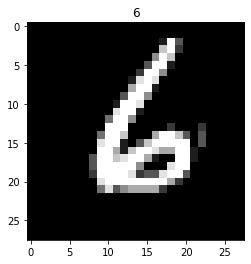

In [150]:
image, label = next(iter(train_loader))
image = image[2].permute(1,2,0)
label = label[2]

plt.imshow(image,cmap='gray',interpolation='none')
plt.title(label.item())
plt.show()

- parameter setting

In [152]:
# 모델
AE = AutoEncoder(input_dim=(1,28,28),
                 encoder_conv_filters=[32,64,64,64],
                 encoder_conv_kernel_size=[3,3,3,3],
                 encoder_conv_strides=[1,2,2,1],
                 decoder_conv_t_filters=[64,64,32,1],
                 decoder_conv_t_kernel_size=[3,3,3,3],
                 decoder_conv_t_strides=[1,2,2,1],
                 z_dim=2).cuda()

# 학습 변수
epochs = 10
lr = 0.0005
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=AE.parameters(),lr=lr)

In [17]:
from tqdm import tqdm

def train(model, train_loader, criterion, optimizer, epoch, epochs):
    model.train()
    train_loss = 0
    for i, (image, label) in tqdm(enumerate(train_loader)):
        image, label = image.cuda(), label.cuda()
        image_recon = model(image)

        loss = criterion(image_recon.cuda(), image)
        loss = torch.sqrt(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'[{epoch+1}/{epochs}] training loss : {train_loss:.2f}')

In [ ]:
if __name__ == '__main__':
    for epoch in range(epochs):
        train(AE, train_loader, criterion, optimizer, epoch, epochs)

### 3.2.5 AE 분석

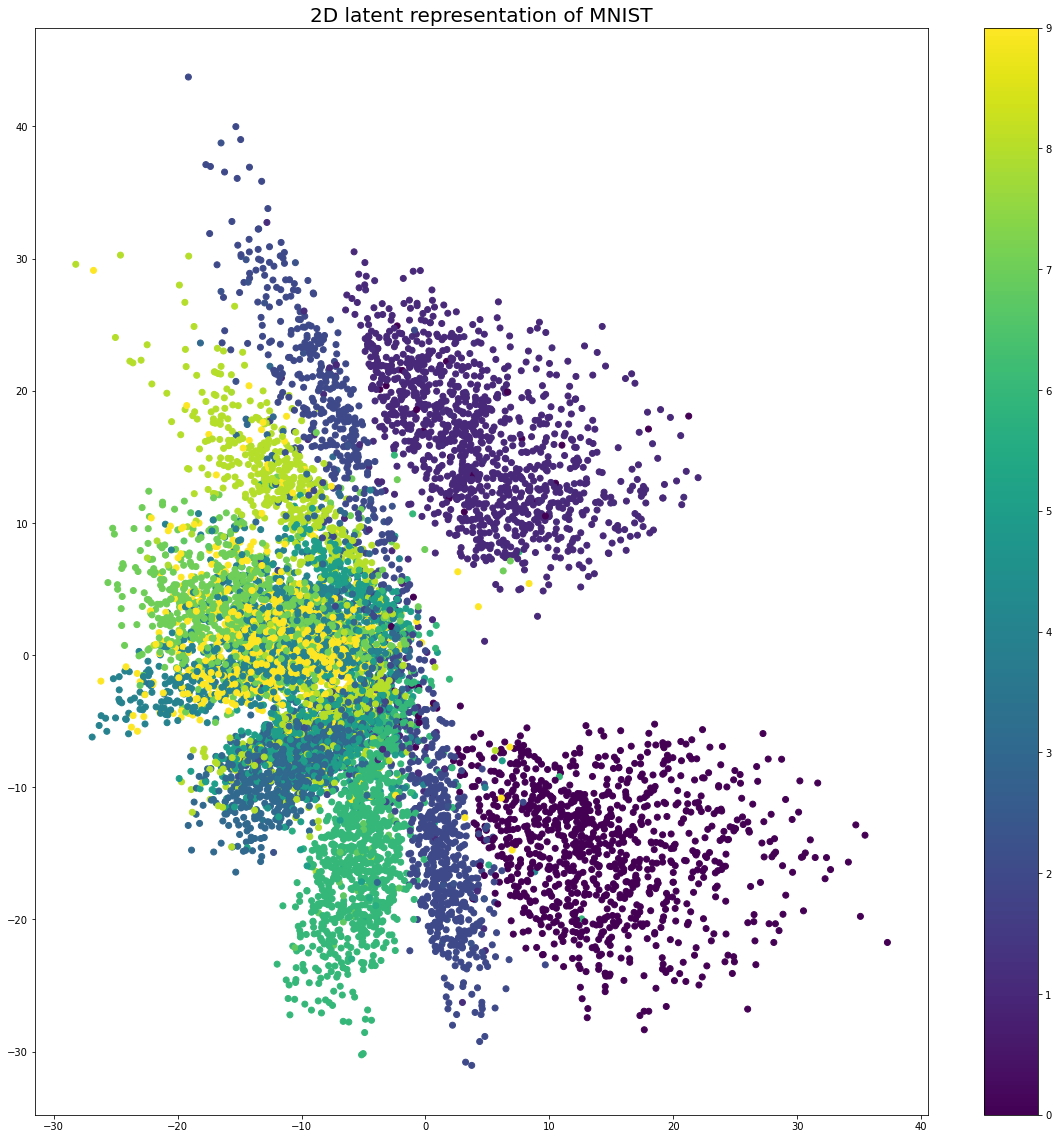

In [177]:
import numpy as np

plt.figure(figsize=(20,20))
for i,(image,label) in enumerate(test_loader):
    latent_vector = AE.encoder(image.cuda())
    latent_vector = latent_vector.detach().cpu().numpy() # (batch, 2)
    label = label.detach().cpu().numpy() # (batch)
    plt.scatter(x=latent_vector[:,0],y=latent_vector[:,1],c=label)
plt.colorbar()
plt.title(label="2D latent representation of MNIST", fontdict={'fontsize':20})
plt.show()

## 3.3 (변경된)미술 전시회

In [192]:
seed = 99

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random_x_coor = torch.rand((10,1))
random_x_coor = random_x_coor*70 - 30 # scale (-30, 40)
random_y_coor = torch.rand((10,1))
random_y_coor = random_y_coor*70 - 30 # scale (-30, 40)
random_points = torch.cat((random_x_coor, random_y_coor),dim=1)

print(random_points.shape)

torch.Size([10, 2])


In [197]:
AE.eval()
y = AE.decoder(random_points.cuda())
y = y.detach().cpu()
print(y.shape)

torch.Size([10, 1, 25, 25])


In [198]:
resized_y = torch.zeros((10,1,28,28))
for i in range(10):
    resized_y[i] = torchvision.transforms.Resize(size=28)(y[i])

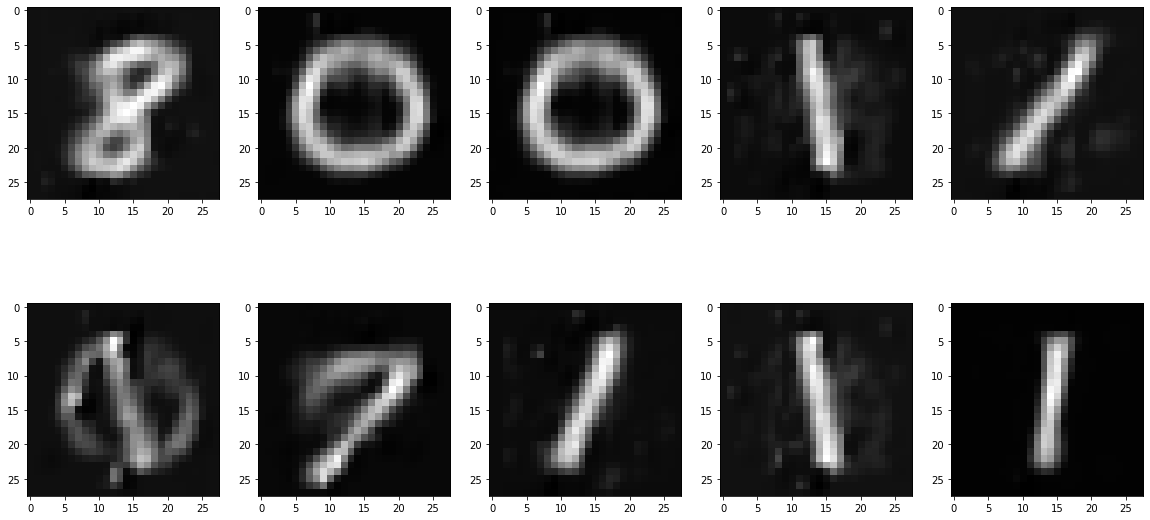

In [206]:
plt.figure(figsize=(20,10))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(resized_y[i].permute(1,2,0), cmap='gray', interpolation='none')

## 3.4 VAE 만들기
- AE를 VAE로 바꿔보자. 인코더와 손실함수만 바꾸면 된다!
- AE encoder가 데이터를 잠재공간의 한 "점"으로 매핑했다면, VAE의 encoder는 데이터를 잠재공간의 n차원 분포에 매핑한다.
    - 분포에서 데이터를 찾으려면 평균과 표준편차가 필요할 것이다
    - 여기서 epsilon은 표준정규분포에서 샘플링한다
$$z=\mu+\sigma\epsilon$$

- Encoder는 입력을 받아 mu와 log(variance)를 출력한다.
- epsilon을 랜덤하게 줘가며 Reconstruction을 살펴 학습한다

### 3.4.1 인코더

In [43]:
class VAE_Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 encoder_conv_filters,
                 encoder_conv_kernel_size,
                 encoder_conv_strides,
                 z_dim):
        super().__init__()
        
        # 네트워크
        self.layers = nn.Sequential()
        for i in range(len(encoder_conv_filters)):
            self.layers.add_module("encoder_cov_"+str(i),
                                   nn.Conv2d(in_channels=(input_dim[0] if i==0 else encoder_conv_filters[i-1]),
                                             out_channels=encoder_conv_filters[i],
                                             kernel_size=encoder_conv_kernel_size[i],
                                             stride=encoder_conv_strides[i]))
            self.layers.add_module("encoder_leakyReLU_"+str(i),
                                   nn.LeakyReLU())
        
        self.shape = self.layers(torch.zeros((1,)+input_dim)).shape
        self.width = self.shape[-1]
        self.height = self.shape[-2]
        self.channel = self.shape[-3]
        self.flatten_dim = self.width * self.height * self.channel

        # linear
        self.linear_mu = nn.Linear(self.flatten_dim, 2)
        self.linear_log_var = nn.Linear(self.flatten_dim, 2)
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def forward(self, x):
        x = self.layers(x)
        x = torch.reshape(x,(x.shape[0],self.flatten_dim))
        mu = self.linear_mu(x)
        log_var = self.linear_log_var(x)
        z = self.reparameterize(mu, log_var)
        return mu, log_var, z

if __name__ == '__main__':
    x = torch.zeros((10,1,28,28))
    encoder = VAE_Encoder(input_dim=(1,28,28),
                          encoder_conv_filters=[32,64,64,64],
                          encoder_conv_kernel_size=[3,3,3,3],
                          encoder_conv_strides=[1,2,2,1],
                          z_dim=2)
    mu, log_var, z = encoder(x)
    print(f'Encoder input shape : {x.shape}')
    print(f'Encoder output shape : [mu : {mu.shape}, log_var : {log_var.shape}, z : {z.shape}]')

Encoder input shape : torch.Size([10, 1, 28, 28])
Encoder output shape : [mu : torch.Size([10, 2]), log_var : torch.Size([10, 2]), z : torch.Size([10, 2])]


In [11]:
torchsummary.summary(encoder.cuda(), (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         LeakyReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 12, 12]          18,496
         LeakyReLU-4           [-1, 64, 12, 12]               0
            Conv2d-5             [-1, 64, 5, 5]          36,928
         LeakyReLU-6             [-1, 64, 5, 5]               0
            Conv2d-7             [-1, 64, 3, 3]          36,928
         LeakyReLU-8             [-1, 64, 3, 3]               0
            Linear-9                    [-1, 2]           1,154
           Linear-10                    [-1, 2]           1,154
Total params: 94,980
Trainable params: 94,980
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.50
Params size (MB): 0.36
Estimated Tot

### 3.4.2 손실 함수

In [61]:
import torch.nn.functional as F

class VAELoss(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha

    def forward(self, y_pred, y_true, mu, log_var):
        bce = F.binary_cross_entropy(y_pred.view(-1, 28*28), y_true.view(-1, 28*28), reduction='sum')
        kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - torch.pow(mu,2) - torch.exp(log_var), dim=1))
        loss =  bce + self.alpha*kl_loss
        return loss

### 3.4.3 학습

In [53]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self,
                 input_dim : tuple,
                 encoder_conv_filters : list,
                 encoder_conv_kernel_size : list,
                 encoder_conv_strides : list,
                 decoder_conv_t_filters : list,
                 decoder_conv_t_kernel_size : list,
                 decoder_conv_t_strides : list,
                 z_dim : int):
        
        super().__init__()

        # 변수 조건 검사
        assert len(encoder_conv_filters)==len(encoder_conv_kernel_size)==len(encoder_conv_strides), "Encoder Conv 매개변수 오류"
        assert len(decoder_conv_t_filters)==len(decoder_conv_t_kernel_size)==len(decoder_conv_t_strides), "Decoder Conv 매개변수 오류"
        assert (z_dim != None) and (z_dim >= 2), "잠재 차원 오류"
        
        # 생성자 변수
        self.input_dim = input_dim
        self.resize = transforms.Resize(input_dim[-2])

        # 네트워크
        self.encoder = VAE_Encoder(input_dim,
                                   encoder_conv_filters,
                                   encoder_conv_kernel_size,
                                   encoder_conv_strides,
                                   z_dim)
        self.decoder = Decoder(input_dim,
                               decoder_conv_t_filters,
                               decoder_conv_t_kernel_size,
                               decoder_conv_t_strides,
                               z_dim,
                               self.encoder.channel,
                               self.encoder.width,
                               self.encoder.height,
                               self.encoder.flatten_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mu, log_var, x = self.encoder(x)
        x = self.decoder(x)
        if tuple(x.shape)[1:] != self.input_dim:
            x_resized = torch.zeros((x.shape[0],)+self.input_dim)
            for batch in range(len(x)):
                x_resized[batch] = self.resize(x[batch])
            return self.sigmoid(x_resized), mu, log_var
        else:
            return self.sigmoid(x), mu, log_var

In [54]:
VAE = VariationalAutoEncoder(input_dim=(1,28,28),
                             encoder_conv_filters=[32,64,64,64],
                             encoder_conv_kernel_size=[3,3,3,3],
                             encoder_conv_strides=[1,2,2,1],
                             decoder_conv_t_filters=[64,64,32,1],
                             decoder_conv_t_kernel_size=[3,3,3,3],
                             decoder_conv_t_strides=[1,2,2,1],
                             z_dim=2).cuda()

torchsummary.summary(VAE, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         LeakyReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 12, 12]          18,496
         LeakyReLU-4           [-1, 64, 12, 12]               0
            Conv2d-5             [-1, 64, 5, 5]          36,928
         LeakyReLU-6             [-1, 64, 5, 5]               0
            Conv2d-7             [-1, 64, 3, 3]          36,928
         LeakyReLU-8             [-1, 64, 3, 3]               0
            Linear-9                    [-1, 2]           1,154
           Linear-10                    [-1, 2]           1,154
      VAE_Encoder-11  [[-1, 2], [-1, 2], [-1, 2]]               0
           Linear-12                  [-1, 576]           1,728
  ConvTranspose2d-13             [-1, 64, 5, 5]          36,928
        LeakyReLU-14             [-1,

In [62]:
# 학습 변수
epochs = 10
lr = 0.0005
criterion = VAELoss(alpha=0.5)
optimizer = torch.optim.Adam(params=VAE.parameters(),lr=lr)

In [63]:
from tqdm import tqdm

def train(model, train_loader, criterion, optimizer, epoch, epochs):
    model.train()
    train_loss = 0
    for i, (image, label) in tqdm(enumerate(train_loader)):
        image, label = image.cuda(), label.cuda()
        image_recon, mu, log_var = model(image)

        loss = criterion(image_recon.cuda(), image, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'[{epoch+1}/{epochs}] training loss : {train_loss:.2f}')

# 학습
if __name__ == '__main__':
    for epoch in range(epochs):
        train(VAE, train_loader, criterion, optimizer, epoch, epochs)

316it [00:06, 52.71it/s]

### 3.4.4 VAE 분석
- 결과가 별로다

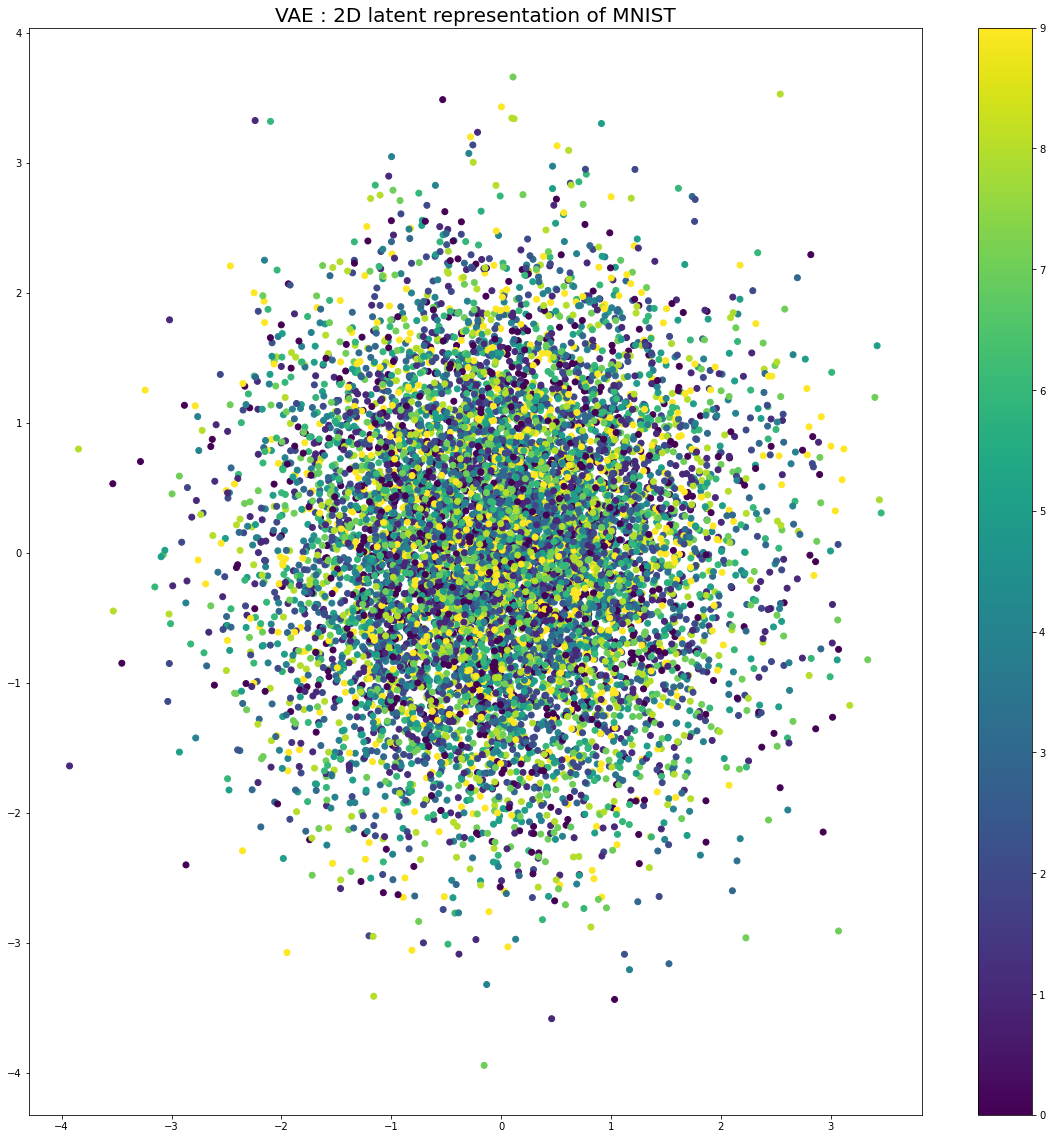

In [34]:
import numpy as np

plt.figure(figsize=(20,20))
for i,(image,label) in enumerate(test_loader):
    mu, log_var, latent_vector = VAE.encoder(image.cuda())
    latent_vector = latent_vector.detach().cpu().numpy() # (batch, 2)
    label = label.detach().cpu().numpy() # (batch)
    plt.scatter(x=latent_vector[:,0],y=latent_vector[:,1],c=label)
plt.colorbar()
plt.title(label="VAE : 2D latent representation of MNIST", fontdict={'fontsize':20})
plt.show()

- Loss의 alpha를 0.1로 내려서 다시 시행

In [36]:
criterion = VAELoss(alpha=0.1)

VAE = VariationalAutoEncoder(input_dim=(1,28,28),
                             encoder_conv_filters=[32,64,64,64],
                             encoder_conv_kernel_size=[3,3,3,3],
                             encoder_conv_strides=[1,2,2,1],
                             decoder_conv_t_filters=[64,64,32,1],
                             decoder_conv_t_kernel_size=[3,3,3,3],
                             decoder_conv_t_strides=[1,2,2,1],
                             z_dim=2).cuda()

# 학습
if __name__ == '__main__':
    for epoch in range(epochs):
        train(VAE, train_loader, criterion, optimizer, epoch, epochs)

1875it [00:35, 53.25it/s]


[1/10] training loss : 621.65


1875it [00:34, 53.94it/s]


[2/10] training loss : 621.65


1875it [00:34, 53.92it/s]


[3/10] training loss : 621.66


1875it [00:34, 53.84it/s]


[4/10] training loss : 621.66


1875it [00:35, 53.35it/s]


[5/10] training loss : 621.64


1875it [00:35, 52.58it/s]


[6/10] training loss : 621.66


1875it [00:34, 53.83it/s]


[7/10] training loss : 621.65


1875it [00:34, 54.31it/s]


[8/10] training loss : 621.64


1875it [00:35, 53.56it/s]


[9/10] training loss : 621.65


1875it [00:34, 54.47it/s]

[10/10] training loss : 621.65


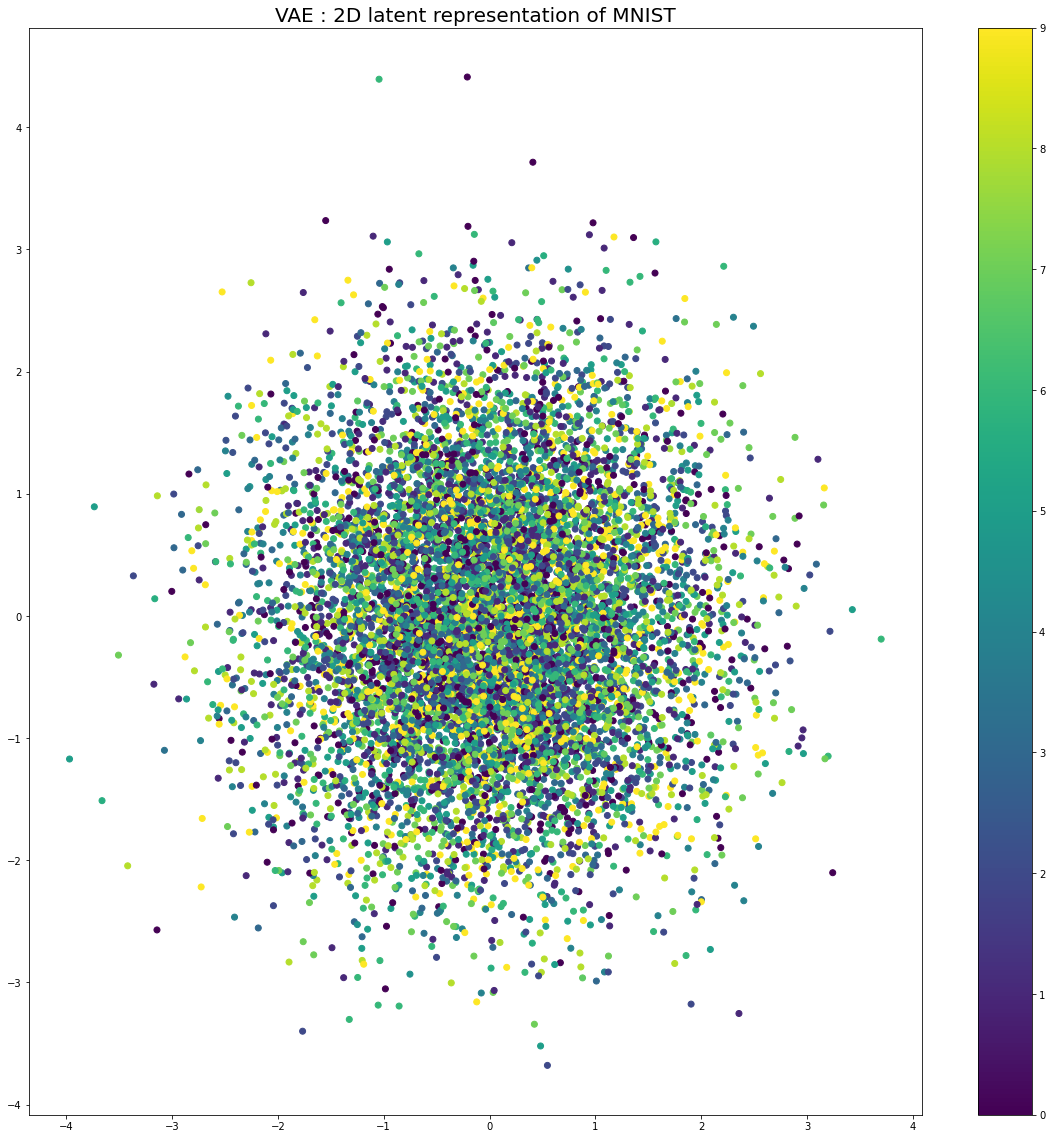

In [41]:
plt.figure(figsize=(20,20))
for i,(image,label) in enumerate(test_loader):
    mu, log_var, latent_vector = VAE.encoder(image.cuda())
    latent_vector = latent_vector.detach().cpu().numpy() # (batch, 2)
    label = label.detach().cpu().numpy() # (batch)
    plt.scatter(x=latent_vector[:,0],y=latent_vector[:,1],c=label)
plt.colorbar()
plt.title(label="VAE : 2D latent representation of MNIST", fontdict={'fontsize':20})
plt.show()

In [38]:
seed = 99

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random_x_coor = torch.rand((10,1))
random_x_coor = random_x_coor*70 - 30 # scale (-30, 40)
random_y_coor = torch.rand((10,1))
random_y_coor = random_y_coor*70 - 30 # scale (-30, 40)
random_points = torch.cat((random_x_coor, random_y_coor),dim=1)

torch.Size([10, 1, 25, 25])


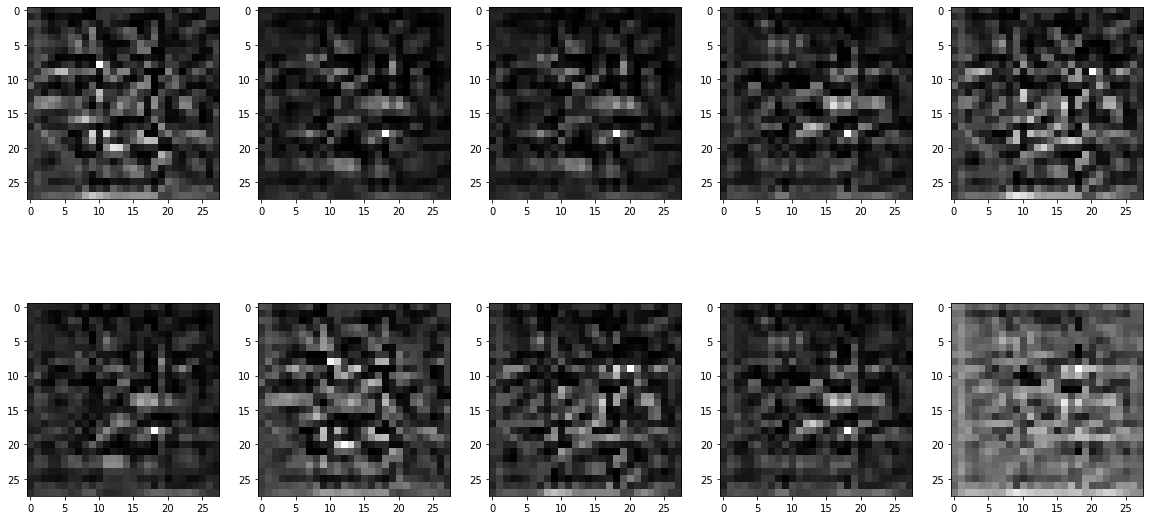

In [40]:
AE.eval()
y = VAE.decoder(random_points.cuda())
y = y.detach().cpu()
print(y.shape)

resized_y = torch.zeros((10,1,28,28))
for i in range(10):
    resized_y[i] = torchvision.transforms.Resize(size=28)(y[i])

plt.figure(figsize=(20,10))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(resized_y[i].permute(1,2,0), cmap='gray', interpolation='none')